# LVC GW Targets

Generate a target list of host galaxies given the 50% and 90% credible localization regions of a GW alert.

In [1]:
from astropy.io import fits

import healpy as hp

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from gw_skymap import compute_quantiles, compute_contours, plot_gwmap

from desitarget.io import read_targets_in_hp, read_targets_in_box, read_targets_in_cap, check_hp_target_dir
from desitarget.targetmask import desi_mask, bgs_mask

## Read GW LALInference Map

Extract localization PDF for a GW event and plot it using the DESI footprint.

Data can be downloaded from the [LVC GraceDB public alert page](https://gracedb.ligo.org/).

In [2]:
fits_file = 'S200224ca_LALInference.fits.gz'

# Read metadata.
hdus = fits.open(fits_file)
header = hdus[1].header

# instruments = header['INSTRUME']
distmean = header['DISTMEAN']
diststd = header['DISTSTD']
origin = header['ORIGIN']
date = header['DATE']

gwmap = hp.read_map(fits_file)
npix = len(gwmap)
nside = hp.npix2nside(npix)

NSIDE = 1024
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING


In [3]:
# Compute GW quantiles.
levels = [0.50, 0.90]
lev50, lev90 = compute_quantiles(levels, gwmap)
print(levels, lev50, lev90)

# # Compute GW quantiles for degraded map.
# gwmap64 = hp.pixelfunc.ud_grade(gwmap, 64) #reduce nside to make it faster
# gwmap64 = gwmap64/np.sum(gwmap64)
# lev50, lev90 = compute_quantiles(levels, gwmap64)
# print(levels, lev50, lev90)

[0.5, 0.9] 5.739633330429371e-05 5.236019043722391e-06


NSIDE = 1024
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 1024
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 45 deg 0.00'.


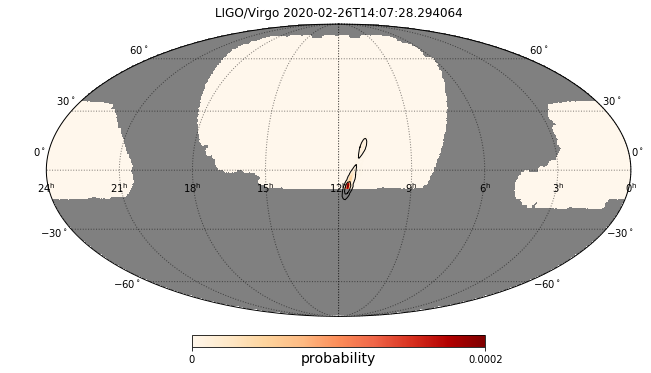

In [4]:
fig = plot_gwmap('S200224ca_LALInference.fits.gz', levels=[0.5, 0.9])
fig.savefig('gw_skymap.png', dpi=100)

In [5]:
maxpix = np.argmax(gwmap)
ra, dec = hp.pix2ang(nside, maxpix, lonlat=True)
print(ra, dec)

173.8916015625 -8.084013907099305


## Load DR8 Targets

Using the code from the [DESI target example notebook](https://github.com/qmxp55/desi_uk_meeting_2019/blob/master/desitarget_local_example.ipynb) created by Omar Macias, extract the targets within a box surrounding the 90% C.I.

In [6]:
# pixids = hp.ring2nest(64, np.arange(len(gwmap64)))
# pix50 = pixids[gwmap64 > lev50]
# pix90 = pixids[gwmap64 > lev90]

pixids = hp.ring2nest(nside, np.arange(npix))
pix50 = pixids[gwmap > lev50]
pix90 = pixids[gwmap > lev90]

In [7]:
# Load sample of resolved DR8 target catalog using HEALPixels above threshold in the GW map.
hpdirname = '/global/projecta/projectdirs/desi/target/catalogs/dr8/0.32.0/targets/main/resolve/bright'
targ90 = read_targets_in_hp(hpdirname, nside=nside, pixlist=pix90)

INFO:io.py:1828:read_target_files: Read 2490257 targets from targets-dr8-hp-8.fits, extension TARGETS...Took 0.7s


INFO:desiutil.log.dlm58.info:Read 2490257 targets from targets-dr8-hp-8.fits, extension TARGETS...Took 0.7s


INFO:io.py:1828:read_target_files: Read 1932469 targets from targets-dr8-hp-26.fits, extension TARGETS...Took 0.6s


INFO:desiutil.log.dlm58.info:Read 1932469 targets from targets-dr8-hp-26.fits, extension TARGETS...Took 0.6s


INFO:io.py:1828:read_target_files: Read 1926328 targets from targets-dr8-hp-27.fits, extension TARGETS...Took 0.5s


INFO:desiutil.log.dlm58.info:Read 1926328 targets from targets-dr8-hp-27.fits, extension TARGETS...Took 0.5s


INFO:io.py:1828:read_target_files: Read 282863 targets from targets-dr8-hp-24.fits, extension TARGETS...Took 0.1s


INFO:desiutil.log.dlm58.info:Read 282863 targets from targets-dr8-hp-24.fits, extension TARGETS...Took 0.1s


In [8]:
len(targ90)

174885

### Select Targets

Identify targets within the 50% and 90% contours, and apply a basic cut on bright BGS objects.

In [9]:
bgs_bright = (targ90['BGS_TARGET'] & bgs_mask['BGS_BRIGHT']) != 0
ra90, dec90 = [targ90[_][bgs_bright] for _ in ['RA', 'DEC']]

rmag = 22.5 - 2.5*np.log10(targ90['FLUX_R'][bgs_bright])
rthr = np.max(rmag)
print('{:8d} targets in 90% C.I. with rmag > {:g}'.format(len(ra90), rthr))

   60430 targets in 90% C.I. with rmag > 19.6947


### Plot the Targets

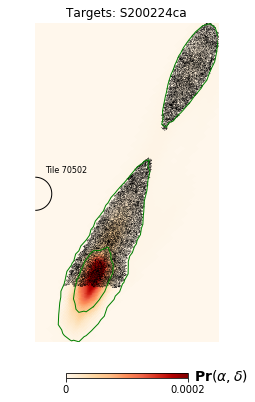

In [10]:
fig = plt.figure(1, figsize=(4,6))

hp.cartview(gwmap, fig=1, cmap='OrRd', lonra=[162.3, 180], latra=[-14.8, 16.0], min=0, max=2e-4,
            title='Targets: S200224ca', unit=r'Pr$(\alpha,\delta)$', flip='astro')
# hp.projplot(ra50, dec50, 'k,', alpha=0.1, lonlat=True);
hp.projplot(ra90, dec90, 'k,', alpha=0.1, lonlat=True);

# Compute GW contours for degraded map.
gwmap64 = hp.pixelfunc.ud_grade(gwmap, 64) #reduce nside to make it faster
gwmap64 = gwmap64/np.sum(gwmap64)
ra_contour, dec_contour = compute_contours(levels, gwmap64)
for i, (rc, dc) in enumerate(zip(ra_contour, dec_contour)):
    hp.projplot(rc, dc, lonlat=True, linewidth=1, c='g')

# Add tile 70502
ra_c, dec_c = 180., -0.5
th = np.radians(np.linspace(0, 360, 181))
ra70502 = ra_c + 1.6*np.cos(th)
dec70502 = dec_c + 1.6*np.sin(th)
hp.projplot(ra70502, dec70502, 'k-', lw=1, lonlat=True)
hp.projtext(ra_c-1, dec_c+2, 'Tile 70502', lonlat=True, fontsize=8)

fig = plt.gcf()
fig.savefig('targlist.png', dpi=150)